# Unintended bias analysis
In this notebook, the CNN model variants are evaluated in terms of their unintended bias following Dixon et al. 2018 (https://doi.org/10.1145/3278721.3278729) and Borkan et al. 2019 (https://doi.org/10.1145/3308560.3317593).

The following metrics are calculated and in some cases plotted:
* Overall AUC
* False Positive Equality Difference and False Negative Equality Difference
* Subgroup AUC
* Background Positive Subgroup Negative AUC and Background Negative Subgroup Positive AUC
* Weighted Bias Score
* Positive Average Equality Gap and Negative Average Equality Gap

In [1]:
# imports 
import bias_metrics
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
from scipy.stats import mannwhitneyu
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, f1_score
import sys
import tensorflow as tf # tf backend
from tqdm import tqdm
from typing import Dict, List, Tuple
import warnings

NUM_MODELS = 10

## Load and predict synthetic data

In [2]:
# load synthetic data
try:
    with open("synth_data_with_preds.pkl", "rb") as f:
        synth_data = pickle.load(f)
    y_synth = synth_data["toxic"]
    print(f"{len(y_synth):,} synthetic sentences")
    display(synth_data.head())

except FileNotFoundError:
    print("Synthetic data with predictions not found. Please run file with the toxicity models to generate them.")

12,780 synthetic sentences


,text,group,identity_term,toxic,identity_lemma,baseline_proba,baseline_pred,CNNorig_proba0,CNNorig_pred0,CNNorig_proba1,...,CNNCDS_proba5,CNNCDS_pred5,CNNCDS_proba6,CNNCDS_pred6,CNNCDS_proba7,CNNCDS_pred7,CNNCDS_proba8,CNNCDS_pred8,CNNCDS_proba9,CNNCDS_pred9
0,kvinder er klamme og generelt bare nederen,F,kvinder,1,kvinde,0.233878,0,0.747900,1,0.457620,...,0.484957,0,0.475498,0,0.902876,1,0.678822,1,0.899668,1
1,piger er klamme og generelt bare nederen,F,piger,1,pige,0.252262,0,0.875201,1,0.614721,...,0.895351,1,0.864768,1,0.986948,1,0.941711,1,0.993594,1
2,damer er klamme og generelt bare nederen,F,damer,1,dame,0.229869,0,0.790222,1,0.317485,...,0.637553,1,0.645807,1,0.942978,1,0.737272,1,0.905351,1
3,koner er klamme og generelt bare nederen,F,koner,1,kone,0.224423,0,0.848518,1,0.424486,...,0.790895,1,0.554593,1,0.851004,1,0.575225,1,0.934626,1
4,kvindfolk er klamme og generelt bare nederen,F,kvindfolk,1,kvindfolk,0.239026,0,0.902128,1,0.634252,...,0.637553,1,0.645807,1,0.942978,1,0.737272,1,0.905351,1


## Overall AUC

In [3]:
# load preprocessed and oversampled data splits
try: 
    with open("data/orig_dataset_splits.pkl", "rb") as f:
        orig_data = pickle.load(f)
except OSError as e:
    print(f"Unable to open file: {e}.\nPlease run the toxicity model file to generate it.", file=sys.stderr)
    
X_train_orig = orig_data["X training preprocessed and oversampled"]
y_train_orig = orig_data["y training preprocessed and oversampled"]
X_test_orig = orig_data["X test preprocessed"]
y_test_orig = orig_data["y test"]

print("Shapes:")
print(X_train_orig.shape, y_train_orig.shape)
print(X_test_orig.shape, y_test_orig.shape)

Shapes:
(3424,) (3424,)
(658,) (658,)


### Baseline

In [4]:
# compute using baseline model (1 variants)
with open("data/overall_aucs_test_baseline.pkl", "rb") as f:
    overall_aucs_test_baseline = pickle.load(f) # regular dataset
overall_aucs_synth_baseline = roc_auc_score(y_synth, synth_data["baseline_proba"]) # synthetic dataset

### Original CNN

In [5]:
with open("data/overall_aucs_test_orig.pkl", "rb") as f:
    overall_aucs_test_orig = pickle.load(f) # regular dataset
overall_aucs_synth_orig = [roc_auc_score(y_synth, synth_data["CNNorig_proba"+str(i)]) for i in range(10)] # synthetic data set

### CDS CNN

In [6]:
with open("data/overall_aucs_test_CDS.pkl", "rb") as f:
    overall_aucs_test_CDS = pickle.load(f) # regular dataset
overall_aucs_synth_CDS = [roc_auc_score(y_synth, synth_data["CNNCDS_proba"+str(i)]) for i in range(10)] # synthetic data set

### Display results

In [9]:
# display the results in a dataframe
overall_aucs_test = {
    "Baseline, test set": {
        "M": np.mean(overall_aucs_test_baseline),
        "Mdn": np.median(overall_aucs_test_baseline),
        "SD": np.std(overall_aucs_test_baseline),
        "Max": np.max(overall_aucs_test_baseline)
        },
    "Orig. CNN, test set": {
        "M": np.mean(overall_aucs_test_orig),
        "Mdn": np.median(overall_aucs_test_orig),
        "SD": np.std(overall_aucs_test_orig),
        "Max": np.max(overall_aucs_test_orig)
        },
    "CDS CNN, test set": {
        "M": np.mean(overall_aucs_test_CDS),
        "Mdn": np.median(overall_aucs_test_CDS),
        "SD": np.std(overall_aucs_test_CDS),
        "Max": np.max(overall_aucs_test_CDS)
        }
}

overall_aucs_synth = {
    "Baseline, synthetic set": {
        "M": np.mean(overall_aucs_synth_baseline),
        "Mdn": np.median(overall_aucs_synth_baseline),
        "SD": np.std(overall_aucs_synth_baseline),
        "Max": np.max(overall_aucs_synth_baseline)
        },
    "Orig. CNN, synthetic set": {
        "M": np.mean(overall_aucs_synth_orig),
        "Mdn": np.median(overall_aucs_synth_orig),
        "SD": np.std(overall_aucs_synth_orig),
        "Max": np.max(overall_aucs_synth_orig)
        },
    "CDS CNN, synthetic set": {
        "M": np.mean(overall_aucs_synth_CDS),
        "Mdn": np.median(overall_aucs_synth_CDS),
        "SD": np.std(overall_aucs_synth_CDS),
        "Max": np.max(overall_aucs_synth_CDS)
        }
}

print("Test set:")
display(round(pd.DataFrame(overall_aucs_test), 3))

print("\n\nSynthetic test set:")
display(round(pd.DataFrame(overall_aucs_synth), 3))

Test set:


,"Baseline, test set","Orig. CNN, test set","CDS CNN, test set"
M,0.765,0.798,0.795
Mdn,0.765,0.798,0.796
SD,0.000,0.008,0.010
Max,0.765,0.808,0.809




Synthetic test set:


,"Baseline, synthetic set","Orig. CNN, synthetic set","CDS CNN, synthetic set"
M,0.575,0.726,0.719
Mdn,0.575,0.726,0.719
SD,0.000,0.013,0.009
Max,0.575,0.746,0.732


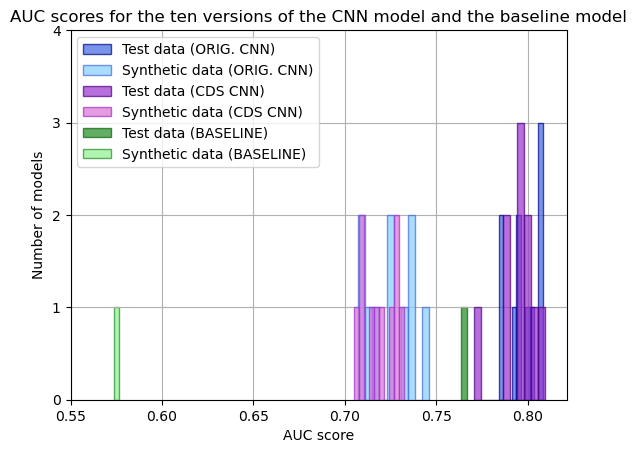

In [14]:
# plot the AUC scores (histogram)
plt.grid(zorder=1)

# orig. CNN
plt.hist(overall_aucs_test_orig, label="Test data (ORIG. CNN)", zorder=2, bins=NUM_MODELS,  edgecolor="darkblue", color="royalblue", alpha=0.7)
plt.hist(overall_aucs_synth_orig, label="Synthetic data (ORIG. CNN)", zorder=3, bins=NUM_MODELS, edgecolor="royalblue", color="lightskyblue", alpha=0.7)

# CDS CNN
plt.hist(overall_aucs_test_CDS, label="Test data (CDS CNN)", zorder=2, bins=NUM_MODELS,  edgecolor="indigo", color="darkorchid", alpha=0.7)
plt.hist(overall_aucs_synth_CDS, label="Synthetic data (CDS CNN)", zorder=3, bins=NUM_MODELS, edgecolor="darkorchid", color="orchid", alpha=0.7)

# baseline
plt.bar(x=overall_aucs_test_baseline, height=1, width=0.003, label="Test data (BASELINE)",edgecolor="darkgreen", color="forestgreen", alpha=0.7)
plt.bar(x=overall_aucs_synth_baseline, height=1, width=0.003, label="Synthetic data (BASELINE)", edgecolor="forestgreen", color="lightgreen", alpha=0.7)

plt.xticks(np.arange(0.55, 0.85, 0.05))
plt.yticks(np.arange(0, 5, 1))

plt.xlabel("AUC score")
plt.ylabel("Number of models")
plt.title("AUC scores for the ten versions of the CNN model and the baseline model")

plt.legend()
plt.show()

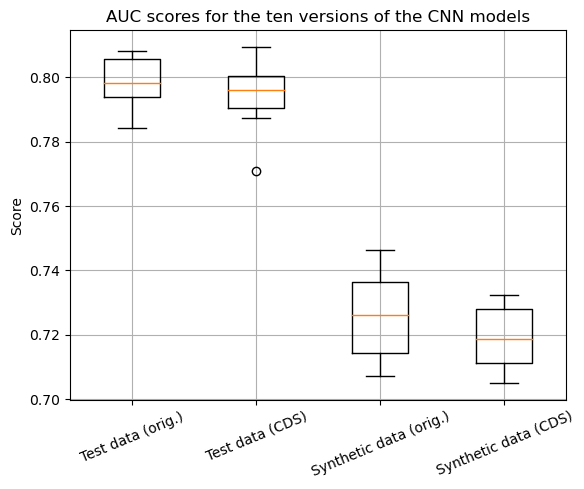

In [15]:
# plot the AUC scores (boxplot)
plt.boxplot([overall_aucs_test_orig, overall_aucs_test_CDS, overall_aucs_synth_orig, overall_aucs_synth_CDS])
plt.xticks(ticks=range(1,5), labels=["Test data (orig.)", "Test data (CDS)", "Synthetic data (orig.)", "Synthetic data (CDS)"], rotation=22.5)
#plt.ylim(0.7, 0.83)
plt.title("AUC scores for the ten versions of the CNN models")
plt.ylabel("Score")
plt.grid()
plt.show()

## FPED and FNED

### Baseline

In [16]:
# calculate per term and overall fpr and fnr for baseline model
per_term_fprs_baseline, overall_fprs_baseline = bias_metrics.compute_per_term_metric(grouping_cond="identity_lemma", metric_name="fpr", data=synth_data, baseline=True)
per_term_fnrs_baseline, overall_fnrs_baseline = bias_metrics.compute_per_term_metric(grouping_cond="identity_lemma", metric_name="fnr", data=synth_data, baseline=True)

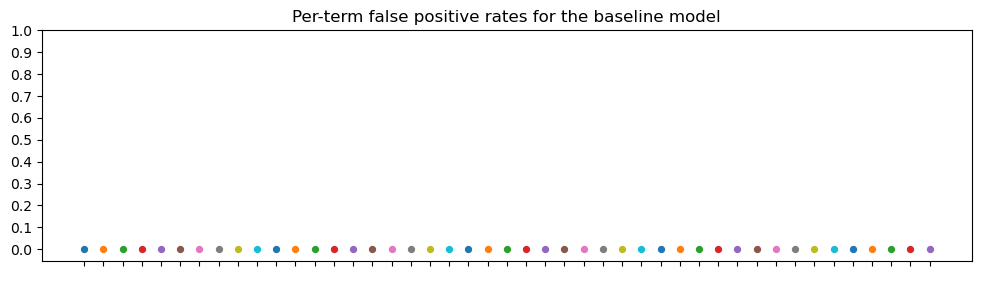

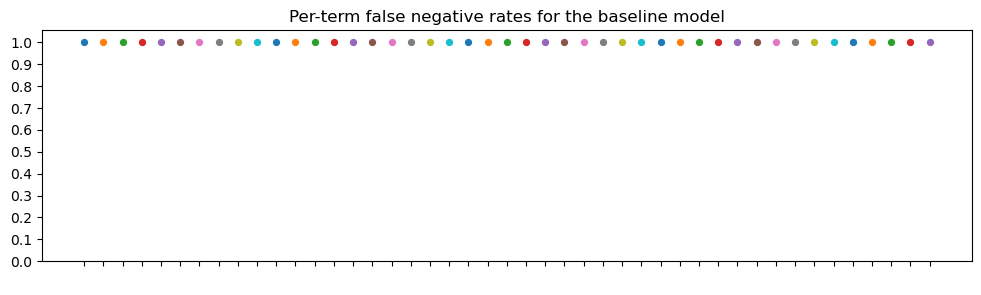

In [17]:
# Plot FPRs
plt.figure(figsize=(12,3))
#order = list(pd.DataFrame(per_term_fprs_baseline).sort_values(by="baseline", ascending=False).index)
plot_df = pd.DataFrame(per_term_fprs_baseline).T#[cnn_order_orig]
for colname in plot_df:
    plt.scatter(x=colname, y=plot_df[colname], zorder=2, s=18)
plt.yticks(np.arange(0, 1.1, .1))
plt.xticks(color="w")
plt.title("Per-term false positive rates for the baseline model")
plt.savefig("plots\\FPRs_baseline2.png", bbox_inches="tight")
plt.show()

# Plot FNRs
plt.figure(figsize=(12,3))
#order = list(pd.DataFrame(per_term_fnrs_baseline).sort_values(by="baseline", ascending=False).index)
plot_df = pd.DataFrame(per_term_fnrs_baseline).T#[cnn_order2_orig]
for colname in plot_df:
    plt.scatter(x=colname, y=plot_df[colname], zorder=2, s=18)
plt.yticks(np.arange(0, 1.1, .1))
plt.xticks(color="w")
plt.title("Per-term false negative rates for the baseline model")
plt.savefig("plots\\FNRs_baseline2.png", bbox_inches="tight")
plt.show()

In [18]:
# compute FPED and FNED for each model variant = overall EREDs
fpeds_baseline = bias_metrics.compute_fped(overall_fprs_baseline["baseline"], per_term_fprs_baseline["baseline"])
fneds_baseline = bias_metrics.compute_fned(overall_fnrs_baseline["baseline"], per_term_fnrs_baseline["baseline"])

# display the results in a dataframe
overall_EREDs = { # EREDs = error rate equality differences
    "FPED": {
        "M": np.mean(fpeds_baseline),
        "Mdn": np.median(fpeds_baseline),
        "SD": np.std(fpeds_baseline),
        "Min": np.min(fpeds_baseline)
        },
    "FNED": {
        "M": np.mean(fneds_baseline),
        "Mdn": np.median(fneds_baseline),
        "SD": np.std(fneds_baseline),
        "Min": np.min(fneds_baseline)
        },
}

print("Baseline:")
display(round(pd.DataFrame(overall_EREDs),3))

Baseline:


,FPED,FNED
M,0.0,0.0
Mdn,0.0,0.0
SD,0.0,0.0
Min,0.0,0.0


### Original CNN

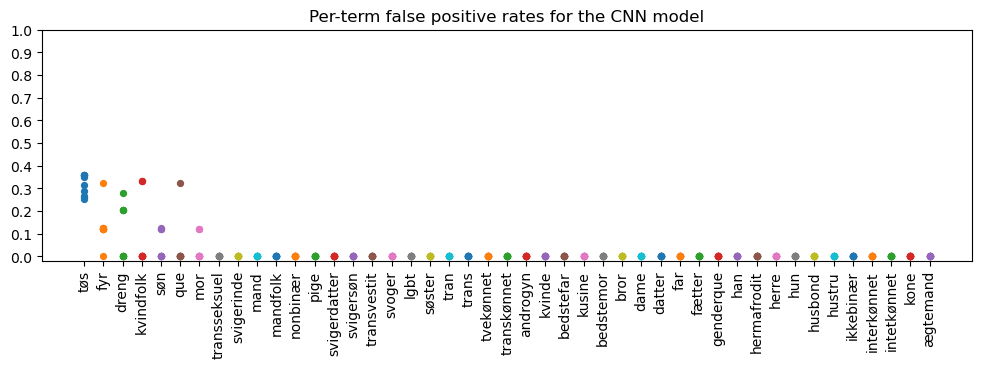

In [19]:
# calculate per term and overall fpr for CNN model
per_term_fprs_orig, overall_fprs_orig = bias_metrics.compute_per_term_metric(grouping_cond="identity_lemma", metric_name="fpr", data=synth_data, model_name="CNNorig")

# plot results
cnn_order_orig = list(pd.DataFrame(per_term_fprs_orig).mean(axis=1).sort_values(ascending=False).index)
bias_metrics.plot_per_term_metrics(per_term_fprs_orig, title="Per-term false positive rates for the CNN model", save_name="FPRs_CNN_orig.png", order=cnn_order_orig)

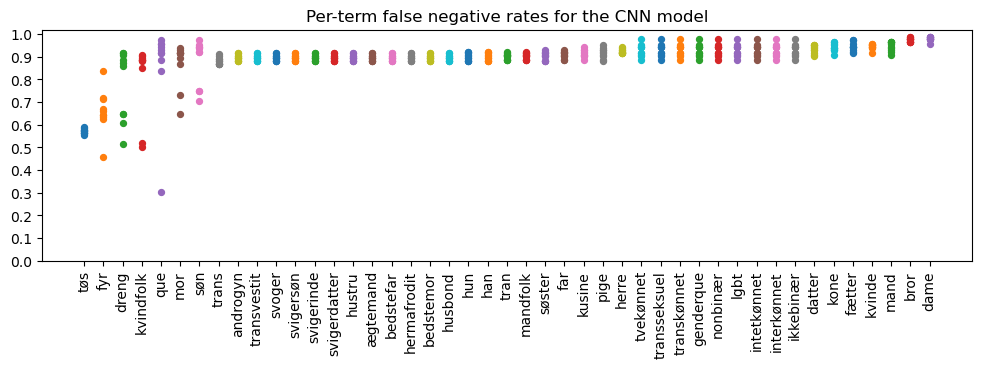

In [20]:
# calculate per term and overall fnr for CNN model
per_term_fnrs_orig, overall_fnrs_orig = bias_metrics.compute_per_term_metric(grouping_cond="identity_lemma", metric_name="fnr", data=synth_data, model_name="CNNorig")

# plot results
cnn_order2_orig = list(pd.DataFrame(per_term_fnrs_orig).mean(axis=1).sort_values(ascending=True).index)
bias_metrics.plot_per_term_metrics(per_term_fnrs_orig, title="Per-term false negative rates for the CNN model", save_name="FNRs_CNN_orig.png", order=cnn_order2_orig)

In [21]:
# compute FPED and FNED for each model variant
fpeds_orig = [bias_metrics.compute_fped(overall_fprs_orig[str(i)], per_term_fprs_orig[str(i)]) for i in range(10)]
fneds_orig = [bias_metrics.compute_fned(overall_fnrs_orig[str(i)], per_term_fnrs_orig[str(i)]) for i in range(10)]

# display the results in a dataframe
overall_EREDs_orig = { # EREDs = error rate equality differences
    "FPED": {
        "M": np.mean(fpeds_orig),
        "Mdn": np.median(fpeds_orig),
        "SD": np.std(fpeds_orig),
        "Min": np.min(fpeds_orig)
        },
    "FNED": {
        "M": np.mean(fneds_orig),
        "Mdn": np.median(fneds_orig),
        "SD": np.std(fneds_orig),
        "Min": np.min(fneds_orig)
        },
}

print("CNN (orig.):")
display(round(pd.DataFrame(overall_EREDs_orig),3))

CNN (orig.):


,FPED,FNED
M,1.290,1.949
Mdn,1.282,1.959
SD,0.384,0.409
Min,0.713,1.318


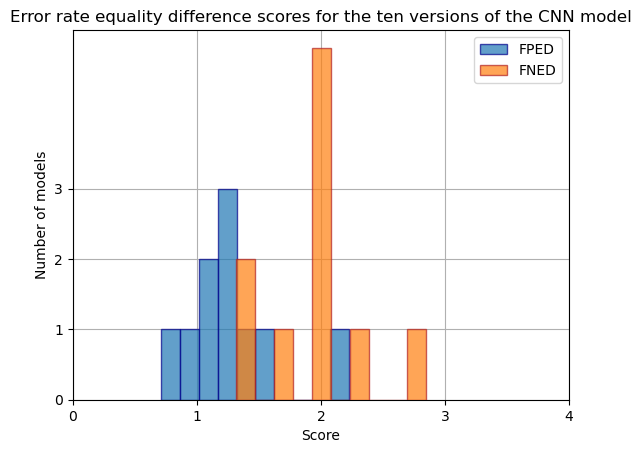

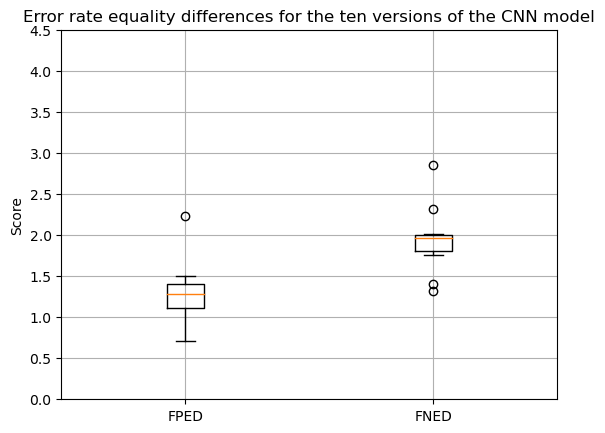

In [22]:
# plot the fped and fned scores (histogram)
plt.grid(zorder=1)
plt.hist(fpeds_orig, label="FPED", zorder=2, bins=NUM_MODELS, edgecolor="darkblue", alpha=0.7)
plt.hist(fneds_orig, label="FNED", zorder=3, bins=NUM_MODELS, edgecolor="firebrick", alpha=0.7)

plt.xticks(np.arange(0, 5, 1))
plt.yticks(np.arange(0, 4, 1))

plt.xlabel("Score")
plt.ylabel("Number of models")
plt.title("Error rate equality difference scores for the ten versions of the CNN model")

plt.legend()
plt.show()

# plot the fped and fned scores (boxplot)
plt.grid()
plt.boxplot([fpeds_orig, fneds_orig])
plt.xticks(ticks=[1,2], labels=["FPED","FNED"])
plt.ylim(0, 4.5)
plt.title("Error rate equality differences for the ten versions of the CNN model")
plt.ylabel("Score")
plt.show()

### CDS CNN

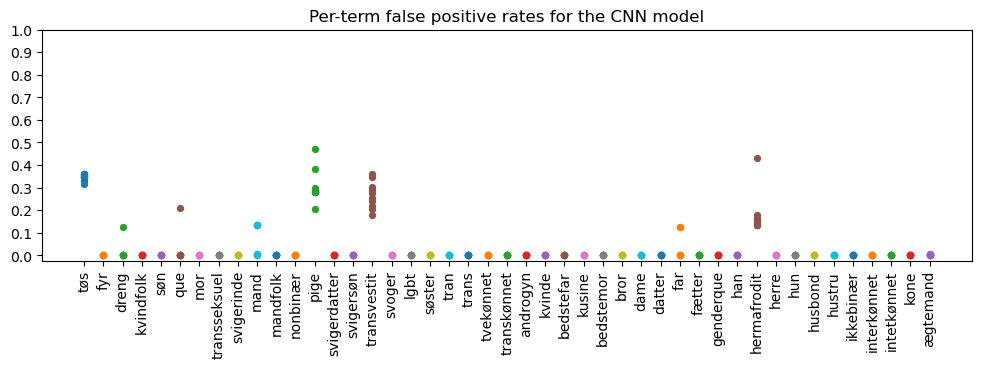

In [24]:
# calculate per term and overall fpr for CNN model
per_term_fprs_CDS, overall_fprs_CDS = bias_metrics.compute_per_term_metric(grouping_cond="identity_lemma", metric_name="fpr", data=synth_data, model_name="CNNCDS")

# plot results
bias_metrics.plot_per_term_metrics(per_term_fprs_CDS, title="Per-term false positive rates for the CNN model", save_name="FPRs_CNN_CDS.png", order=cnn_order_orig)

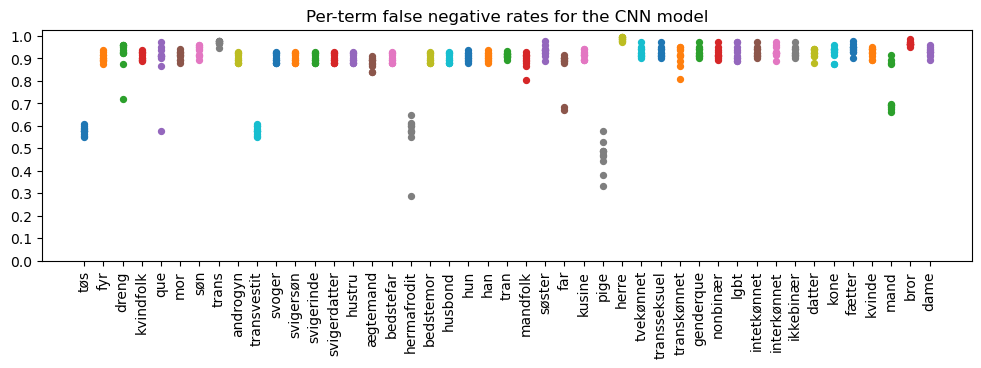

In [25]:
# calculate per term and overall fnr for CNN model
per_term_fnrs_CDS, overall_fnrs_CDS = bias_metrics.compute_per_term_metric(grouping_cond="identity_lemma", metric_name="fnr", data=synth_data, model_name="CNNCDS")

# plot results
bias_metrics.plot_per_term_metrics(per_term_fnrs_CDS, title="Per-term false negative rates for the CNN model", save_name="FNRs_CNN_CDS.png", order=cnn_order2_orig)

In [27]:
# compute FPED and FNED for each model variant
fpeds_CDS = [bias_metrics.compute_fped(overall_fprs_CDS[str(i)], per_term_fprs_CDS[str(i)]) for i in range(10)]
fneds_CDS = [bias_metrics.compute_fned(overall_fnrs_CDS[str(i)], per_term_fnrs_CDS[str(i)]) for i in range(10)]

# display the results in a dataframe
overall_EREDs_CDS = { # EREDs = error rate equality differences
    "FPED": {
        "M": np.mean(fpeds_CDS),
        "Mdn": np.median(fpeds_CDS),
        "SD": np.std(fpeds_CDS),
        "Min": np.min(fpeds_CDS)
        },
    "FNED": {
        "M": np.mean(fneds_CDS),
        "Mdn": np.median(fneds_CDS),
        "SD": np.std(fneds_CDS),
        "Min": np.min(fneds_CDS)
        },
}

print("CNN (CDS):")
display(round(pd.DataFrame(overall_EREDs_CDS),3))

CNN (CDS):


,FPED,FNED
M,2.191,3.152
Mdn,2.089,3.162
SD,0.407,0.436
Min,1.705,2.597


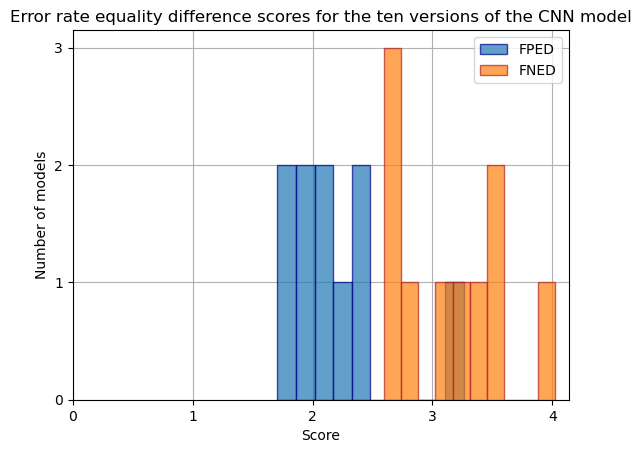

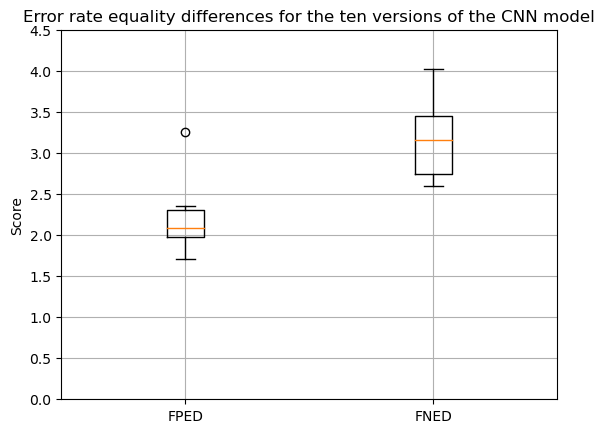

In [28]:
# plot the fped and fned scores (histogram)
plt.grid(zorder=1)
plt.hist(fpeds_CDS, label="FPED", zorder=2, bins=NUM_MODELS, edgecolor="darkblue", alpha=0.7)
plt.hist(fneds_CDS, label="FNED", zorder=3, bins=NUM_MODELS, edgecolor="firebrick", alpha=0.7)

plt.xticks(np.arange(0, 5, 1))
plt.yticks(np.arange(0, 4, 1))

plt.xlabel("Score")
plt.ylabel("Number of models")
plt.title("Error rate equality difference scores for the ten versions of the CNN model")

plt.legend()
plt.show()

# plot the fped and fned scores (boxplot)
plt.grid()
plt.boxplot([fpeds_CDS, fneds_CDS])
plt.xticks(ticks=[1,2], labels=["FPED","FNED"])
plt.ylim(0, 4.5)
plt.title("Error rate equality differences for the ten versions of the CNN model")
plt.ylabel("Score")
plt.show()

## AUC and AEG scores (termwise metrics)

In [29]:
# create custom cmaps
colors = [(0, 0, 0), (0.2, 0, 0.2), (0.7, 0.4, 0.5), (0.8, 0.6, 0.7), (0.85, 0.85, 0.85), (1, 1, 1)]
AUC_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)
AEG_cmap = plt.get_cmap('PiYG', 11)

### Baseline

In [30]:
# BASELINE
# for each term, calculate scores for each model variant, and take the average

per_term_scores_baseline = dict()

for (t_name, t_df) in tqdm(synth_data.groupby("identity_lemma")): # for each term (t=term)
    
    # subset data for calculations
    bgr_df = synth_data[synth_data["identity_lemma"]!=t_name] # background data = data that doens"t mention the current identity term
    bgr_pos = bgr_df[bgr_df["toxic"]==1] # background positive
    bgr_neg = bgr_df[bgr_df["toxic"]==0] # background negative
    t_pos = t_df[t_df["toxic"]==1] # subgroup positive
    t_neg = t_df[t_df["toxic"]==0] # subgroup negative
    bpsn_df = pd.concat([bgr_pos, t_neg])   
    bnsp_df = pd.concat([bgr_neg, t_pos])
    
    scores = {
        "group": t_df["group"].unique()[0],
        "subAUC_avg": roc_auc_score(t_df["toxic"], t_df["baseline_proba"]),
        "BPSN_avg": roc_auc_score(bpsn_df["toxic"], bpsn_df["baseline_proba"]),
        "BNSP_avg": roc_auc_score(bnsp_df["toxic"], bnsp_df["baseline_proba"]),
        "posAEG_avg": bias_metrics.compute_posAEG(subgroup_pos=t_pos, bgr_pos=bgr_pos, col_name="baseline_proba"),
        "negAEG_avg": bias_metrics.compute_negAEG(subgroup_neg=t_neg, bgr_neg=bgr_neg, col_name="baseline_proba")
    }
    
    per_term_scores_baseline[t_name] = scores

100%|██████████| 45/45 [00:02<00:00, 15.93it/s]


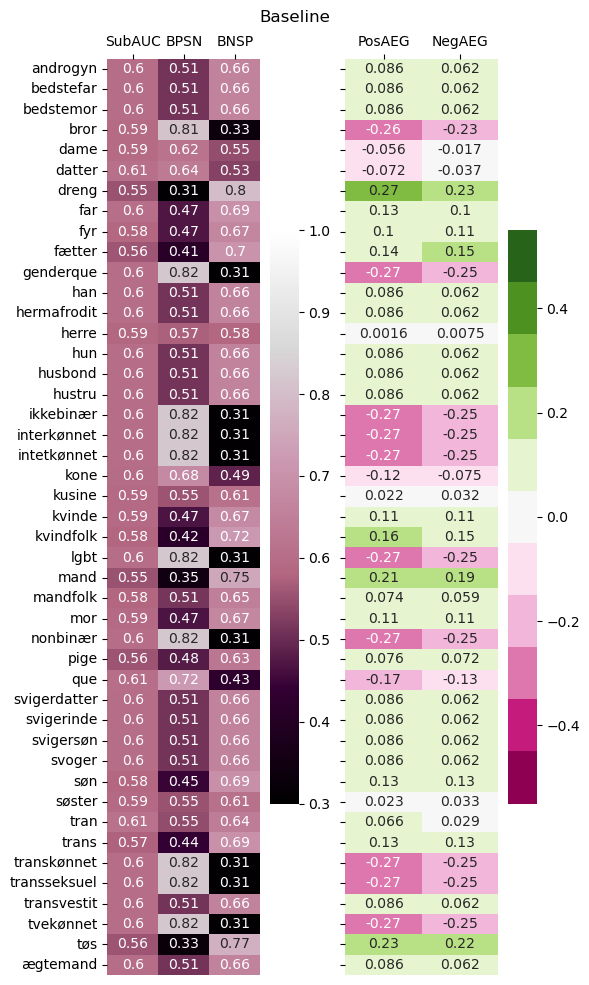

In [31]:
score_df_baseline = pd.DataFrame(per_term_scores_baseline).T
score_df_baseline.rename(columns={"subAUC_avg":"SubAUC", "BPSN_avg": "BPSN", "BNSP_avg": "BNSP", "posAEG_avg": "PosAEG", "negAEG_avg": "NegAEG"}, inplace=True)
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(6,10))

AUC_df_baseline = pd.DataFrame(score_df_baseline.loc[:,"SubAUC":"BNSP"], dtype="float")
sns.heatmap(AUC_df_baseline, ax=axes[0], annot=True, vmin=0.3, vmax=1.0, cmap=AUC_cmap)

AEG_df_baseline = pd.DataFrame(score_df_baseline.loc[:,"PosAEG":"NegAEG"], dtype="float")
sns.heatmap(AEG_df_baseline, ax=axes[1], annot=True, vmin=-0.55, vmax=0.55, cmap=AEG_cmap)

axes[0].xaxis.tick_top()
axes[1].xaxis.tick_top()

plt.suptitle("Baseline")
plt.tight_layout()
plt.savefig("plots\\per_term_metrics_baseline.png", bbox_inches="tight")
plt.show()

### Original CNN

In [32]:
# CNN
# for each term, calculate scores for each model variant, and take the average

per_term_scores_orig = dict()

for (t_name, t_df) in tqdm(synth_data.groupby("identity_lemma")): # for each term (t=term)
    
    # subset data for calculations
    bgr_df = synth_data[synth_data["identity_lemma"]!=t_name] # background data = data that doens"t mention the current identity term
    bgr_pos = bgr_df[bgr_df["toxic"]==1] # background positive
    bgr_neg = bgr_df[bgr_df["toxic"]==0] # background negative
    t_pos = t_df[t_df["toxic"]==1] # subgroup positive
    t_neg = t_df[t_df["toxic"]==0] # subgroup negative
    bpsn_df = pd.concat([bgr_pos, t_neg])   
    bnsp_df = pd.concat([bgr_neg, t_pos])
    
    subAUCs, BPSNs, BNSPs = [], [], []
    posAEGs, negAEGs = [], []
    
    for model_i in range(10): # for each model variant
        
        # subAUC = AUC(sub_pos and sub_neg), i.e. entire identity subset
        subAUCs.append(roc_auc_score(t_df["toxic"], t_df["CNNorig_proba"+str(model_i)]))
    
        # BPSN = AUC(background positive AND subgroup negative)
        BPSNs.append(roc_auc_score(bpsn_df["toxic"], bpsn_df["CNNorig_proba"+str(model_i)]))
    
        # BNSP = AUC(background negative AND subgroup positive)
        BNSPs.append(roc_auc_score(bnsp_df["toxic"], bnsp_df["CNNorig_proba"+str(model_i)]))
        
        # AEGs
        posAEGs.append(bias_metrics.compute_posAEG(subgroup_pos=t_pos, bgr_pos=bgr_pos, col_name="CNNorig_proba"+str(model_i)))
        negAEGs.append(bias_metrics.compute_negAEG(subgroup_neg=t_neg, bgr_neg=bgr_neg, col_name="CNNorig_proba"+str(model_i)))
    
    scores = {
        "group": t_df["group"].unique()[0],
        "subAUC_avg": np.mean(subAUCs),
        "BPSN_avg": np.mean(BPSNs),
        "BNSP_avg": np.mean(BNSPs),
        "posAEG_avg": np.mean(posAEGs),
        "negAEG_avg": np.mean(negAEGs),
        "subAUC_max": np.max(subAUCs),
        "BPSN_max": np.max(BPSNs),
        "BNSP_max": np.max(BNSPs),
        "posAEG_max": np.max(posAEGs),
        "negAEG_max": np.max(negAEGs),
        "subAUC_all": subAUCs,
        "BPSN_all": BPSNs,
        "BNSP_all": BNSPs,
        "posAEG_all": posAEGs,
        "negAEG_all": negAEGs
    }
    
    per_term_scores_orig[t_name] = scores

100%|██████████| 45/45 [00:15<00:00,  2.95it/s]


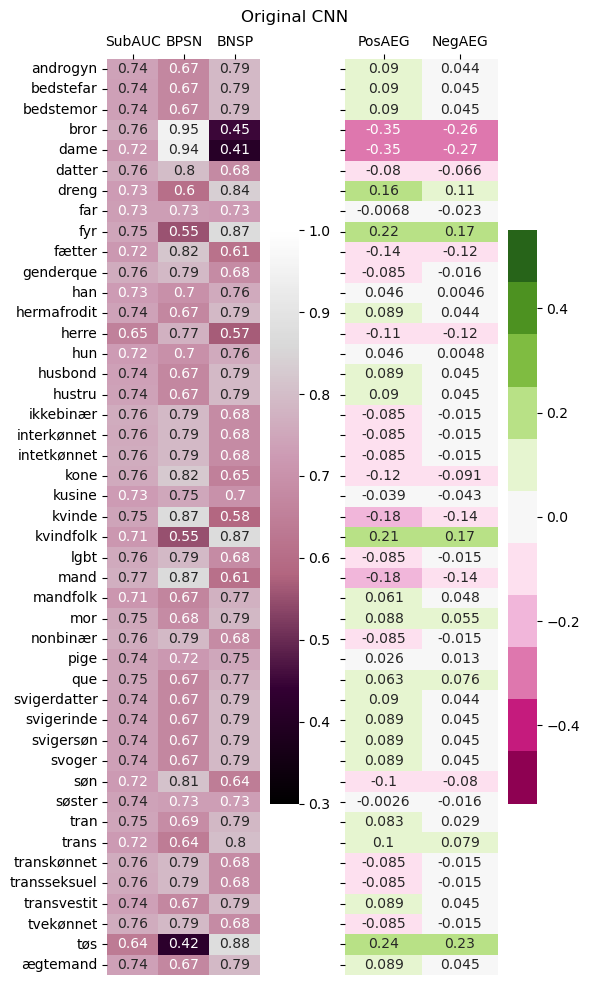

In [33]:
# plot avgs
score_df_orig = pd.DataFrame(per_term_scores_orig).T
score_df_orig.rename(columns={"subAUC_avg":"SubAUC", "BPSN_avg": "BPSN", "BNSP_avg": "BNSP", "posAEG_avg": "PosAEG", "negAEG_avg": "NegAEG"}, inplace=True)
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(6,10))

AUC_df_orig = pd.DataFrame(score_df_orig.loc[:,"SubAUC":"BNSP"], dtype="float")
sns.heatmap(AUC_df_orig, ax=axes[0], annot=True, vmin=0.3, vmax=1.0, cmap=AUC_cmap)

AEG_df_orig = pd.DataFrame(score_df_orig.loc[:,"PosAEG":"NegAEG"], dtype="float")
sns.heatmap(AEG_df_orig, ax=axes[1], annot=True, vmin=-0.55, vmax=0.55, cmap=AEG_cmap)

axes[0].xaxis.tick_top()
axes[1].xaxis.tick_top()

plt.suptitle("Original CNN")
plt.tight_layout()
plt.savefig("plots\\per_term_metrics_CNN_orig.png", bbox_inches="tight")
plt.show()

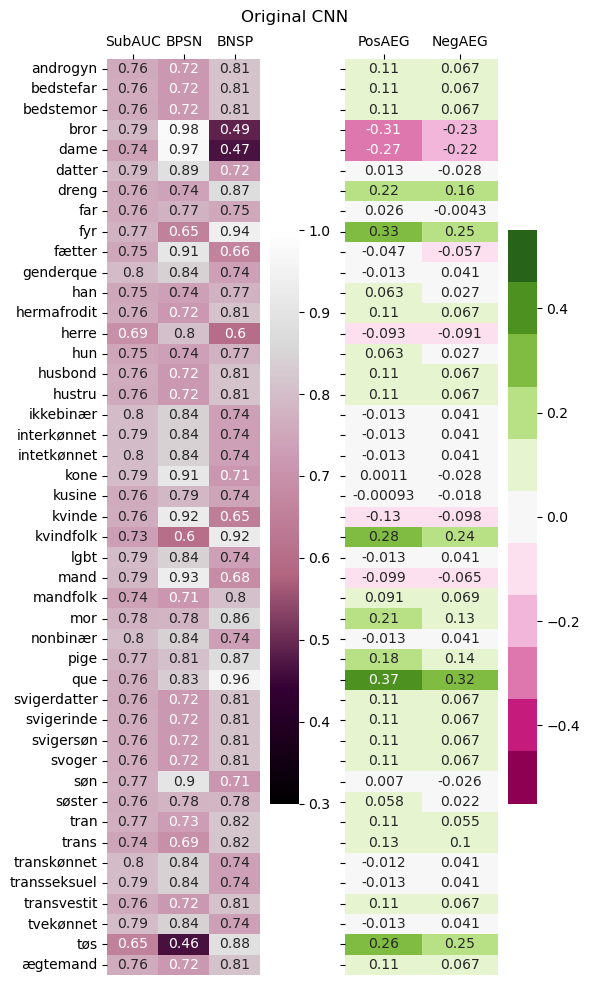

In [35]:
# plot maxs
score_df_orig = pd.DataFrame(per_term_scores_orig).T
score_df_orig.rename(columns={"subAUC_max":"SubAUC", "BPSN_max": "BPSN", "BNSP_max": "BNSP", "posAEG_max": "PosAEG", "negAEG_max": "NegAEG"}, inplace=True)
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(6,10))

AUC_df_orig = pd.DataFrame(score_df_orig.loc[:,"SubAUC":"BNSP"], dtype="float")
sns.heatmap(AUC_df_orig, ax=axes[0], annot=True, vmin=0.3, vmax=1.0, cmap=AUC_cmap)

AEG_df_orig = pd.DataFrame(score_df_orig.loc[:,"PosAEG":"NegAEG"], dtype="float") # TODO max is not "retvisende" for these as it is the best result for aegs < 0 (closer to 0), but not for those > 0 (farther from 0)
sns.heatmap(AEG_df_orig, ax=axes[1], annot=True, vmin=-0.55, vmax=0.55, cmap=AEG_cmap)

axes[0].xaxis.tick_top()
axes[1].xaxis.tick_top()

plt.suptitle("Original CNN")
plt.tight_layout()
plt.savefig("plots\\per_term_metrics_CNN_orig.png", bbox_inches="tight")
plt.show()

### CDS CNN

In [36]:
# CNN
# for each term, calculate scores for each model variant, and take the average

per_term_scores_CDS = dict()

for (t_name, t_df) in tqdm(synth_data.groupby("identity_lemma")): # for each term (t=term)
    
    # subset data for calculations
    bgr_df = synth_data[synth_data["identity_lemma"]!=t_name] # background data = data that doens"t mention the current identity term
    bgr_pos = bgr_df[bgr_df["toxic"]==1] # background positive
    bgr_neg = bgr_df[bgr_df["toxic"]==0] # background negative
    t_pos = t_df[t_df["toxic"]==1] # subgroup positive
    t_neg = t_df[t_df["toxic"]==0] # subgroup negative
    bpsn_df = pd.concat([bgr_pos, t_neg])   
    bnsp_df = pd.concat([bgr_neg, t_pos])
    
    subAUCs, BPSNs, BNSPs = [], [], []
    posAEGs, negAEGs = [], []
    
    for model_i in range(10): # for each model variant
        
        # subAUC = AUC(sub_pos and sub_neg), i.e. entire identity subset
        subAUCs.append(roc_auc_score(t_df["toxic"], t_df["CNNCDS_proba"+str(model_i)]))
    
        # BPSN = AUC(background positive AND subgroup negative)
        BPSNs.append(roc_auc_score(bpsn_df["toxic"], bpsn_df["CNNCDS_proba"+str(model_i)]))
    
        # BNSP = AUC(background negative AND subgroup positive)
        BNSPs.append(roc_auc_score(bnsp_df["toxic"], bnsp_df["CNNCDS_proba"+str(model_i)]))
        
        # AEGs
        posAEGs.append(bias_metrics.compute_posAEG(subgroup_pos=t_pos, bgr_pos=bgr_pos, col_name="CNNCDS_proba"+str(model_i)))
        negAEGs.append(bias_metrics.compute_negAEG(subgroup_neg=t_neg, bgr_neg=bgr_neg, col_name="CNNCDS_proba"+str(model_i)))
    
    scores = {
        "group": t_df["group"].unique()[0],
        "subAUC_avg": np.mean(subAUCs),
        "BPSN_avg": np.mean(BPSNs),
        "BNSP_avg": np.mean(BNSPs),
        "posAEG_avg": np.mean(posAEGs),
        "negAEG_avg": np.mean(negAEGs),
        "subAUC_max": np.max(subAUCs),
        "BPSN_max": np.max(BPSNs),
        "BNSP_max": np.max(BNSPs),
        "posAEG_max": np.max(posAEGs),
        "negAEG_max": np.max(negAEGs),
        "subAUC_all": subAUCs,
        "BPSN_all": BPSNs,
        "BNSP_all": BNSPs,
        "posAEG_all": posAEGs,
        "negAEG_all": negAEGs
    }
    
    per_term_scores_CDS[t_name] = scores

100%|██████████| 45/45 [00:15<00:00,  2.93it/s]


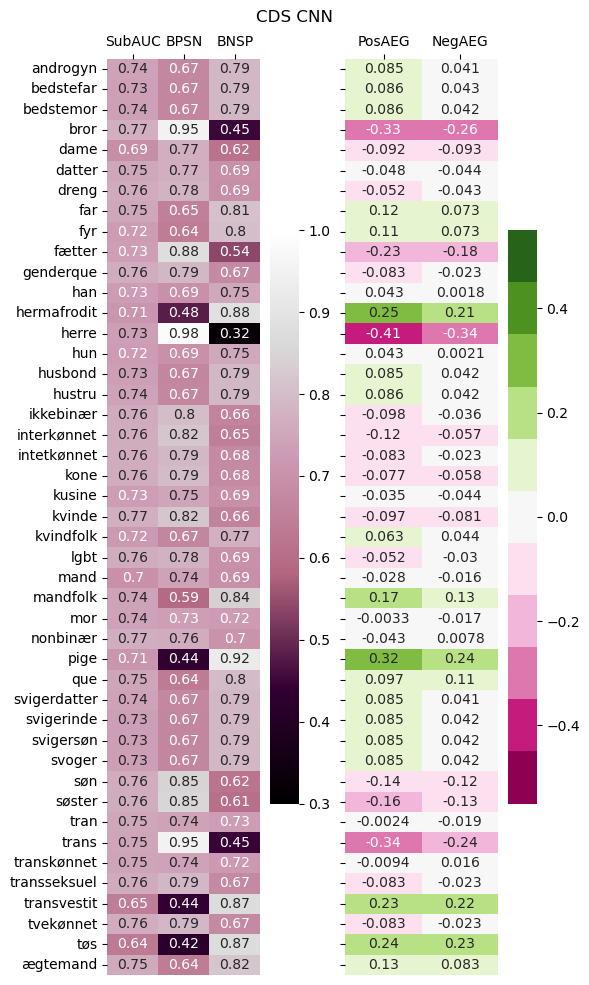

In [38]:
# plot avgs
score_df_CDS = pd.DataFrame(per_term_scores_CDS).T
score_df_CDS.rename(columns={"subAUC_avg":"SubAUC", "BPSN_avg": "BPSN", "BNSP_avg": "BNSP", "posAEG_avg": "PosAEG", "negAEG_avg": "NegAEG"}, inplace=True)
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(6,10))

AUC_df_CDS = pd.DataFrame(score_df_CDS.loc[:,"SubAUC":"BNSP"], dtype="float")
sns.heatmap(AUC_df_CDS, ax=axes[0], annot=True, vmin=0.3, vmax=1.0, cmap=AUC_cmap)

AEG_df_CDS = pd.DataFrame(score_df_CDS.loc[:,"PosAEG":"NegAEG"], dtype="float")
sns.heatmap(AEG_df_CDS, ax=axes[1], annot=True, vmin=-0.55, vmax=0.55, cmap=AEG_cmap)

axes[0].xaxis.tick_top()
axes[1].xaxis.tick_top()

plt.suptitle("CDS CNN")
plt.tight_layout()
plt.savefig("plots\\per_term_metrics_CNN_CDS.png", bbox_inches="tight")
plt.show()

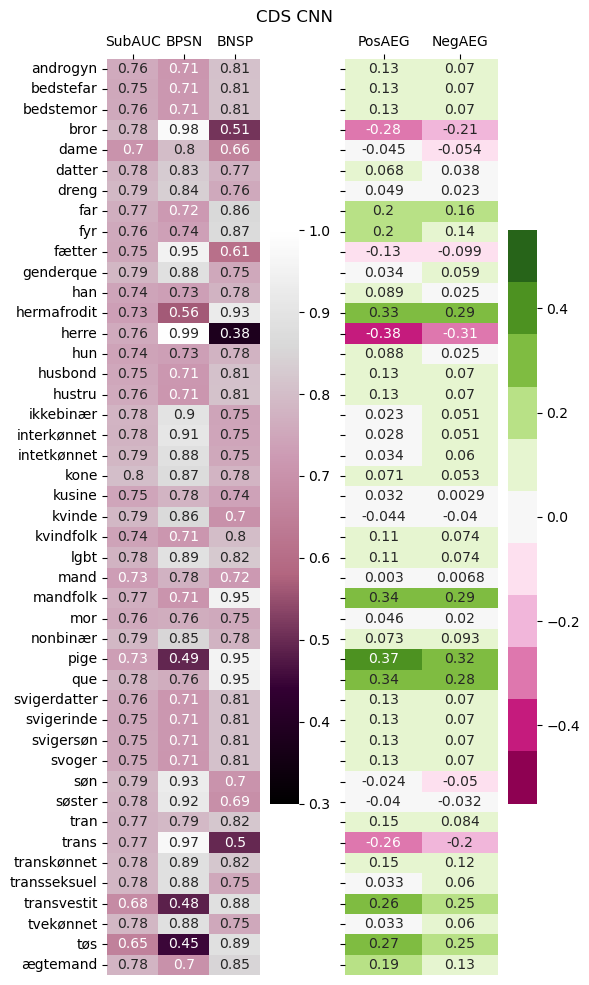

In [39]:
# plot maxs
score_df_CDS = pd.DataFrame(per_term_scores_CDS).T
score_df_CDS.rename(columns={"subAUC_max":"SubAUC", "BPSN_max": "BPSN", "BNSP_max": "BNSP", "posAEG_max": "PosAEG", "negAEG_max": "NegAEG"}, inplace=True)
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(6,10))

AUC_df_CDS = pd.DataFrame(score_df_CDS.loc[:,"SubAUC":"BNSP"], dtype="float")
sns.heatmap(AUC_df_CDS, ax=axes[0], annot=True, vmin=0.3, vmax=1.0, cmap=AUC_cmap)

AEG_df_CDS = pd.DataFrame(score_df_CDS.loc[:,"PosAEG":"NegAEG"], dtype="float") # TODO max is not "retvisende" for these as it is the best result for aegs < 0 (closer to 0), but not for those > 0 (farther from 0)
sns.heatmap(AEG_df_CDS, ax=axes[1], annot=True, vmin=-0.55, vmax=0.55, cmap=AEG_cmap)

axes[0].xaxis.tick_top()
axes[1].xaxis.tick_top()

plt.suptitle("CDS CNN")
plt.tight_layout()
plt.savefig("plots\\per_term_metrics_CNN_CDS.png", bbox_inches="tight")
plt.show()

## Weighted bias score

In [41]:
# TODO is this also avg? or max?
print("Baseline:")
print("Weighted bias score:", round(bias_metrics.get_weighted_bias_score(bias_df=AUC_df_baseline, overall_auc=np.mean(overall_aucs_synth_baseline)), 4))

print("\nOrig. CNN:")
print("Weighted bias score:", round(bias_metrics.get_weighted_bias_score(bias_df=AUC_df_orig, overall_auc=np.mean(overall_aucs_synth_orig)), 4))

print("\nCDS CNN:")
print("Weighted bias score:", round(bias_metrics.get_weighted_bias_score(bias_df=AUC_df_CDS, overall_auc=np.mean(overall_aucs_synth_CDS)), 4))

Baseline:
Weighted bias score: 0.5125

Orig. CNN:
Weighted bias score: 0.7316

CDS CNN:
Weighted bias score: 0.7088
